<a href="https://colab.research.google.com/github/brostudio000/tugas-akhir/blob/main/Copy_of_wmh2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DataGenerator

In [1]:
import os
import nibabel as nib
import numpy as np

data_path = "/content/drive/MyDrive/Colab_Notebooks/WMH_Dataset/training/Utrecht/"
seg_samples = [os.path.join(data_path, sample, "wmh_modified.nii.gz") for sample in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, sample))]

saved_values = []
max_nb_values = 0
for sample in seg_samples:
    seg_img = nib.load(sample).get_fdata()
    unique_values = np.unique(seg_img)
    nb_unique_values = len(unique_values)

    if nb_unique_values > max_nb_values:
        max_nb_values = nb_unique_values
        saved_values = unique_values

print(f"Maximum number of values in all segmentation images: {max_nb_values}")
print(f"Values: {saved_values}")


Maximum number of values in all segmentation images: 2
Values: [0. 1.]


In [ ]:
#import os
#import nibabel as nib
#import numpy as np

data_path = "/content/drive/MyDrive/Colab_Notebooks/WMH_Dataset/training/Utrecht/"
seg_samples = [os.path.join(data_path, sample, "wmh.nii.gz") for sample in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, sample))]

for sample in seg_samples:
    seg_img = nib.load(sample)
    seg_data = seg_img.get_fdata()

    # Remove class 2 (assuming it's represented by the value 2)
    seg_data[seg_data == 2] = 0

    # Save the modified segmentation data
    modified_seg_img = nib.Nifti1Image(seg_data, seg_img.affine)
    nib.save(modified_seg_img, sample.replace("wmh.nii.gz", "wmh_modified.nii.gz"))


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import nibabel as nib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

VOLUME_START_AT = 7
VOLUME_SLICES = 30
IMG_SIZE = 256
N_CHANNELS = 2

data_path = "/content/drive/MyDrive/Colab_Notebooks/WMH_Dataset/training/Utrecht"

# List all patients
patients = os.listdir(data_path)

# Split the dataset into train and validation sets
patients_train, patients_val = train_test_split(patients, test_size=0.15, random_state=42)

# Split the train set into the real train set and a test set
patients_train, patients_test = train_test_split(patients_train, test_size=0.15, random_state=42)

# Print data distribution
print(f"Train length: {len(patients_train)}")
print(f"Validation length: {len(patients_val)}")
print(f"Test length: {len(patients_test)}")

class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, data_path, batch_size=1, img_size=IMG_SIZE, n_channels=N_CHANNELS, n_classes=2, shuffle=True):
        self.list_IDs = list_IDs
        self.data_path = data_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        X = np.zeros((self.batch_size * VOLUME_SLICES, self.img_size, self.img_size, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, self.img_size, self.img_size, self.n_classes))

        for c, i in enumerate(list_IDs_temp):
            t1_path = os.path.join(self.data_path, i, 'pre', 'T1.nii.gz')
            flair_path = os.path.join(self.data_path, i, 'pre', 'FLAIR.nii.gz')
            seg_path = os.path.join(self.data_path, i, 'wmh_modified.nii.gz')

            t1 = nib.load(t1_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(t1[:, :, j + VOLUME_START_AT], (self.img_size, self.img_size))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (self.img_size, self.img_size))

                # Resize and create one-hot encoded mask
                mask_resized = cv2.resize(seg[:, :, j + VOLUME_START_AT], (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)
                y[j + VOLUME_SLICES * c, :, :, :] = tf.keras.utils.to_categorical(mask_resized, num_classes=self.n_classes)

        return X / np.max(X), y

# Create data generators
train_generator = DataGenerator(patients_train, data_path, n_channels=N_CHANNELS)
val_generator = DataGenerator(patients_val, data_path, n_channels=N_CHANNELS)
test_generator = DataGenerator(patients_test, data_path, n_channels=N_CHANNELS)

Train length: 14
Validation length: 3
Test length: 3


### U-Net architecture

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
from tensorflow.keras.models import Model
def unet_model(inputs, ker_init, dropout):
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(3, 1, activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

In [49]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
from tensorflow.keras.models import Model
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv4)

    pool5 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv6 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool5)
    conv6 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv6)
    drop6 = Dropout(dropout)(conv6)

    up8 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(drop6))
    merge8 = concatenate([conv4,up8], axis = 3)
    conv8 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv8))
    merge9 = concatenate([conv3,up9], axis = 3)
    conv9 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up10 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv9))
    merge10 = concatenate([conv2,up10], axis = 3)
    conv10 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge10)
    conv10 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv10)

    up11 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv10))
    merge11 = concatenate([conv,up11], axis = 3)
    conv11 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge11)
    conv11 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv11)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv11))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv12 = Conv2D(2, 1, activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv12)

### Metrics for training

In [50]:
import keras.backend as K
# Compute metric between the predicted segmentation and the ground truth
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 2
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [51]:
# Define input data shape
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the model
model = unet_model(input_layer, 'he_normal', 0.5)

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=3), dice_coef, precision])

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 128, 128, 64), (None, 256, 256, 64)]

### Training

In [ ]:
from keras.callbacks import CSVLogger
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.000001, verbose=1),

    keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.h5',
                             verbose=1, save_best_only=True, save_weights_only = True),

    CSVLogger('training.log', separator=',', append=False)
]

In [ ]:
model.fit(train_generator,
          epochs=50,
          steps_per_epoch=len(patients_train),
          callbacks=callbacks,
          validation_data=val_generator)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 4.1982 - accuracy: 0.9225 - mean_io_u_1: 0.4137 - dice_coef: 0.4536 - precision: 0.9225
Epoch 1: val_loss improved from inf to 0.22702, saving model to model_.01-0.227021.h5
14/14 [==============================] - 96s 3s/step - loss: 4.1982 - accuracy: 0.9225 - mean_io_u_1: 0.4137 - dice_coef: 0.4536 - precision: 0.9225 - val_loss: 0.2270 - val_accuracy: 0.9943 - val_mean_io_u_1: 0.2500 - val_dice_coef: 0.4490 - val_precision: 0.9943 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 0.0583 - accuracy: 0.9948 - mean_io_u_1: 0.5885 - dice_coef: 0.4943 - precision: 0.9948
Epoch 2: val_loss improved from 0.22702 to 0.03494, saving model to model_.02-0.034941.h5
14/14 [==============================] - 31s 2s/step - loss: 0.0583 - accuracy: 0.9948 - mean_io_u_1: 0.5885 - dice_coef: 0.4943 - precision: 0.9948 - val_loss: 0.0349 - val_accuracy: 0.9943 - val_mean_io_u_1: 0.5927 - val_dice_coef: 

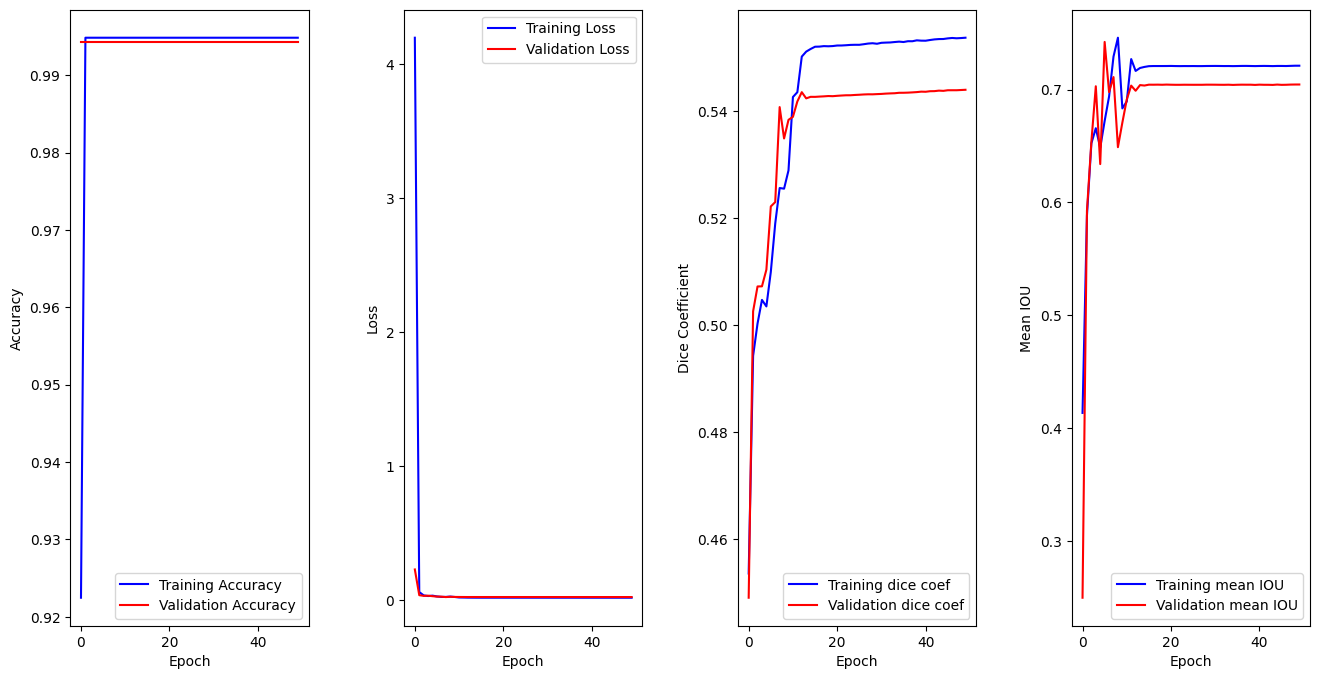

In [ ]:
import pandas as pd
# Read the CSVlogger file that contains all our metrics (accuracy, loss, dice_coef, ...) of our training
history = pd.read_csv('training.log', sep=',', engine='python')

# Plot training and validation metrics
fig, axs = plt.subplots(1, 4, figsize=(16, 8))

axs[0].plot(history['epoch'], history['accuracy'], 'b', label='Training Accuracy')
axs[0].plot(history['epoch'], history['val_accuracy'], 'r', label='Validation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(history['epoch'], history['loss'], 'b', label='Training Loss')
axs[1].plot(history['epoch'], history['val_loss'], 'r', label='Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

axs[2].plot(history['epoch'], history['dice_coef'], 'b', label='Training dice coef')
axs[2].plot(history['epoch'], history['val_dice_coef'], 'r', label='Validation dice coef')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Dice Coefficient')
axs[2].legend()

axs[3].plot(history['epoch'], history['mean_io_u_1'], 'b', label='Training mean IOU')
axs[3].plot(history['epoch'], history['val_mean_io_u_1'], 'r', label='Validation mean IOU')
axs[3].set_xlabel('Epoch')
axs[3].set_ylabel('Mean IOU')
axs[3].legend()

# Add space between subplots
plt.subplots_adjust(wspace=0.4)

plt.show()

In [ ]:
# Compile a model and load our saved weights
IMG_SIZE = 256
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

best_saved_model = unet_model(input_layer, 'he_normal', 0.5)

best_saved_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                         metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=3), dice_coef, precision] )

best_saved_model.load_weights('/content/model_.08-0.020791.h5')

### Prediction

In [ ]:
#model_path = ('/content/model_.15-0.034663.h5')
#loaded_model = tf.keras.models.load_model(model_path)

def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 2
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

#loaded_model = tf.keras.models.load_model(model_path, custom_objects= {'dice_coef': dice_coef, 'precision': precision})

def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1_path = os.path.join(sample_path, 'pre', 'T1.nii.gz')
    flair_path = os.path.join(sample_path, 'pre', 'FLAIR.nii.gz')

    # Extract the data from these paths
    t1 = nib.load(t1_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(t1[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    # Send our images to the CNN model and return predicted segmentation
    return model.predict(X / np.max(X), verbose=1)

1/1 [==============================] - 0s 27ms/step
Patient number:  25


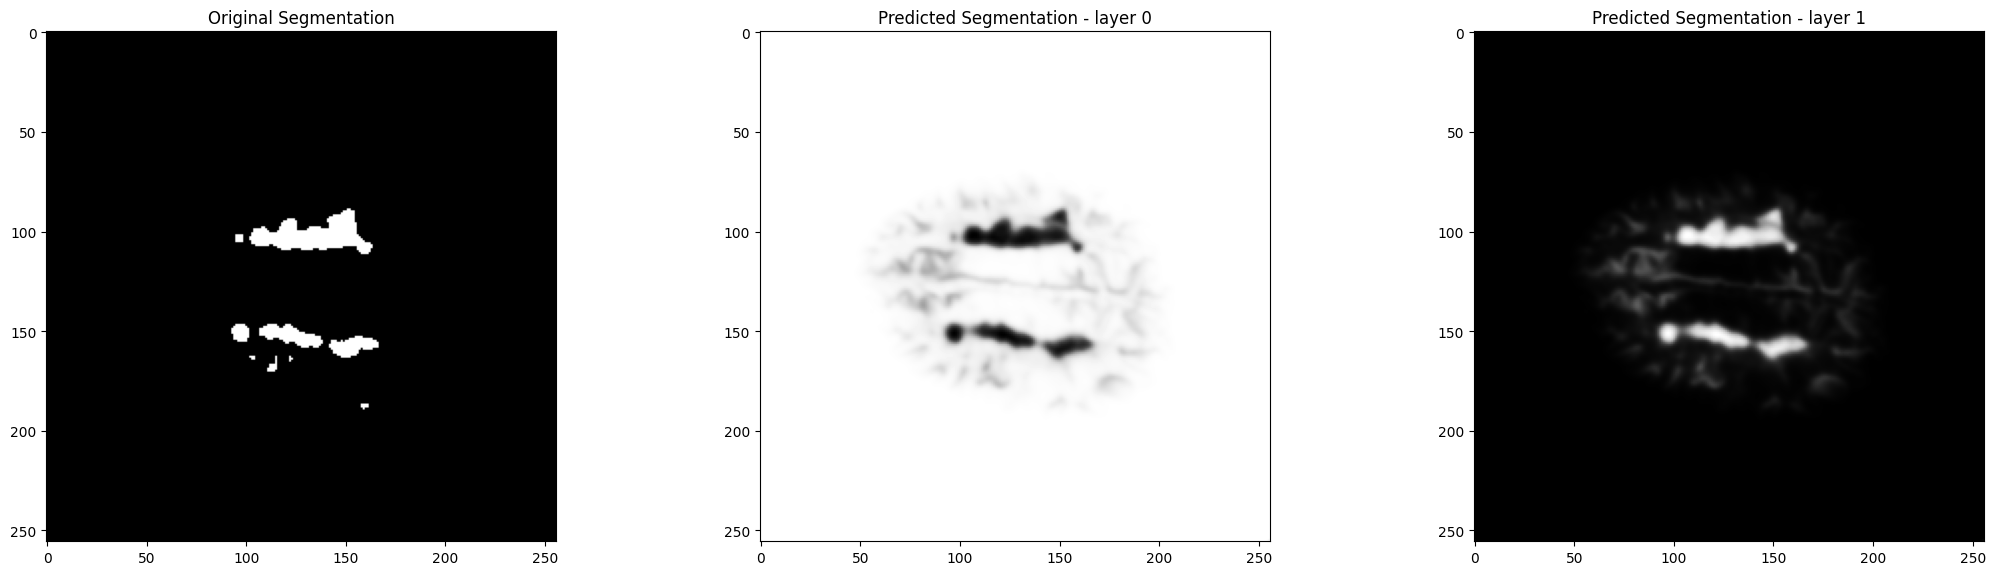

In [ ]:
import random
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm, model):
    # Choose a random patient
    random_sample = random.choice(samples_list)

    # Get path of this patient
    random_sample_path = os.path.join(data_path, random_sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)

    # Load patient's original segmentation (Ground truth)
    seg_path = os.path.join(random_sample_path, 'wmh_modified.nii.gz')
    seg = nib.load(seg_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions.
    seg = cv2.resize(seg[:, :, slice_to_plot + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # Ensure slice_to_plot is within the valid range
    num_slices_predicted = predicted_seg.shape[0]
    slice_to_plot = min(slice_to_plot, num_slices_predicted - 1)

    # Differentiate segmentations by their labels
    #all = predicted_seg[slice_to_plot, :, :, 1:3]  # Keep only classes 1 and 2
    zero = predicted_seg[slice_to_plot, :, :, 0]    # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot, :, :, 1]    # Isolation of class 1, White Matter Hyperintensity
    #second = predicted_seg[slice_to_plot, :, :, 2]   # Isolation of class 2, Other Pathology

    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 3, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    # Layers 1, 2, 3
    #axstest[1].imshow(all[:, :, 0], cmap, norm)  # Display the first channel
    #axstest[1].set_title('Predicted Segmentation - all layers')

    # Layer 0
    axstest[1].imshow(zero, cmap, norm)
    axstest[1].set_title('Predicted Segmentation - layer 0')

    # Layer 1
    axstest[2].imshow(first, cmap, norm)
    axstest[2].set_title('Predicted Segmentation - layer 1')

    # Layer 2
    #axstest[4].imshow(second, cmap, norm)
    #axstest[4].set_title('Predicted Segmentation - layer 2')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.4)

    plt.show()

# Example usage
show_predicted_segmentations(patients_test, slice_to_plot=22, cmap='gray', norm=None, model=model)